# Sleep stages classification of rodent EEG signal

## Introduction

Source: https://github.com/shamPJ/Material-for-MLpython-course/blob/master/projects/Projects_EEG.ipynb

"Electroencephalography (EEG) is an electrophysiological monitoring method to record electrical activity of the brain. EEG measures voltage fluctuations resulting from ionic current within the neurons of the brain" (Link: [Wikipedia](https://en.wikipedia.org/wiki/Electroencephalography))

In this project, I will build a classifier for automatically assigning four brain activity states (Wake state, NREM sleep, REM sleep, Artefact) based on the EEG recording.

[image source](https://www.nature.com/articles/s41598-019-51269-8)
<img src="eeg_example.webp" alt="Drawing" style="width: 800px;"/>

<p><center>Example of brain state classification</center></p>

## Problem Formulation

### Data points: 
EEG recordings of 34 animals with 4000 epochs (each epoch is a 4-second recordings) per animals, and since the sampling rate is frequency 200 Hz, 4-second recording contains 800 sample values). For that reason, the whole EEG recordings of all 34 animals are stored as an array with dimension of 34x4000x800 and this data can be loaded from the file 'EEG.npy' with function `numpy.load()`.


### Features:
Features are 800 sample points - 4s recordings of epochs.


### Labels:
Every 4-second interval is assigned with 1 of 4 brain activity states as labels of 4000 EEG recordings of 34 animals: Wake state, NREM sleep, REM sleep, Artefact. Labels data can also be retrieved from the file 'EEG_codes.npy' with method `numpy.load()`. 

**Note:** Some epochs with label '8' (and associated EEG signal) are not analyzed and would be removed from classification.


### Hypothesis spaces/Training models and Loss function:
1. [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
2. [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
<br><br>

Other potential hypothesis spaces:
1. [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
2. [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier)
3. [RidgeClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html#sklearn.linear_model.RidgeClassifierCV)
4. [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#classification)
5. [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
6. [Multi-layer perceptron (MLP) classifier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification)

## Method

1. Get data 
2. Cleaning data (removing epochs with label '8')
3. Fitting model
4. Validate model (using K-fold CV)
5. Fixing hyperparameter
6. Comeback to step 4 until find a suitable hyperparameter
7. Compare training and validation accuracy between models with `sklearn.metrics`

In [1]:
# Import neccessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# Set precision for decimal number to 2 number, presenting maximum 10 values in the list
np.set_printoptions(precision=2, suppress=True, threshold = 7)

### Get data and labels 

In [3]:
features = np.load('EEG.npy')
labels = np.load('EEG_codes.npy')

In [4]:
print(features.shape)
print(labels.shape)

(34, 4000, 800)
(34, 4000)


### Data visualization

In [5]:
label_names = ['0 - Wake state', '1 - NREM sleep', '2 - REM sleep', '3 - Artefact', '8 - Not analyzed']

{'0 - Wake state': 80809, '1 - NREM sleep': 49860, '2 - REM sleep': 4701, '3 - Artefact': 604, '8 - Not analyzed': 26}


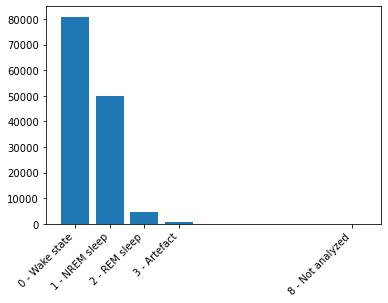

In [6]:
label_value, counts = np.unique(labels, return_counts=True)
print(dict(zip(label_names, counts)))
plt.bar(label_value, counts, tick_label=label_names)
plt.xticks(rotation=45, ha='right')
plt.show()

### Data cleaning

As shown from the graph above, the data is highly imbalanced. I would use under-sample the data by deleting 95% data points from class '0' and 90% from class '1'. The ratio of class 0:1:2 would be 1:1.2:1.1

While doing this, I should also need to avoid clearing most of samples from some specific animals only since this could make the training data lose variance.

In [7]:
from random import seed
from random import sample

def under_sample_data(X, y):
    """
    The function randomly extract the same numbers of data from the 
    first 2 class to achieve the equal distribution among the dataset
    :param X: feature vector
    :param y: label vector
    """

    animal_range, epoch_range, eeg_range = X.shape

    trimmed_X = X[y == 2]
    trimmed_y = np.ones(np.size(trimmed_X,0)) * 2
    
    for ani_ind in range(animal_range):
        rem_count = np.count_nonzero(y[ani_ind, :] == 2)
        animal_labels = y[ani_ind,:]
        
        # Get list of indices of data from first 2 classes
        wake_index = np.where(animal_labels == 0)
        nrem_index = np.where(animal_labels == 1)
        
        # Randomly trim data
        seed(ani_ind)
        rand_wake_ind = sample(list(wake_index[0]), rem_count) 
        rand_nrem_ind = sample(list(nrem_index[0]), rem_count)      
        
        wake_feature = X[ani_ind, rand_wake_ind, :]
        nrem_feature = X[ani_ind, rand_nrem_ind, :]
        wake_label = np.zeros(rem_count)
        nrem_label = np.ones(rem_count)
        
        # Add to new feature and labels arrays 
        trimmed_X = np.concatenate((trimmed_X, wake_feature, nrem_feature), axis=0)
        trimmed_y = np.concatenate((trimmed_y, wake_label, nrem_label), axis=0)

    # Save trimmed data to new file
    np.save('EEG_features.npy', trimmed_X)
    np.save('EEG_labels.npy', trimmed_y)

under_sample_data(features, labels)

Now, I can use new trimmed data for training

In [8]:
features = np.load('EEG_features.npy')
labels = np.load('EEG_labels.npy')

In [9]:
print(features.shape)
print(labels.shape)

(14103, 800)
(14103,)


 Then, I would like to filter out all artefact and unanalyzed data.

In [10]:
for c in range(3):
    index_list = np.where(labels == c)
    print('Type', c, index_list)

Type 0 (array([ 4701,  4702,  4703, ..., 14032, 14033, 14034], dtype=int64),)
Type 1 (array([ 4709,  4710,  4711, ..., 14100, 14101, 14102], dtype=int64),)
Type 2 (array([   0,    1,    2, ..., 4698, 4699, 4700], dtype=int64),)


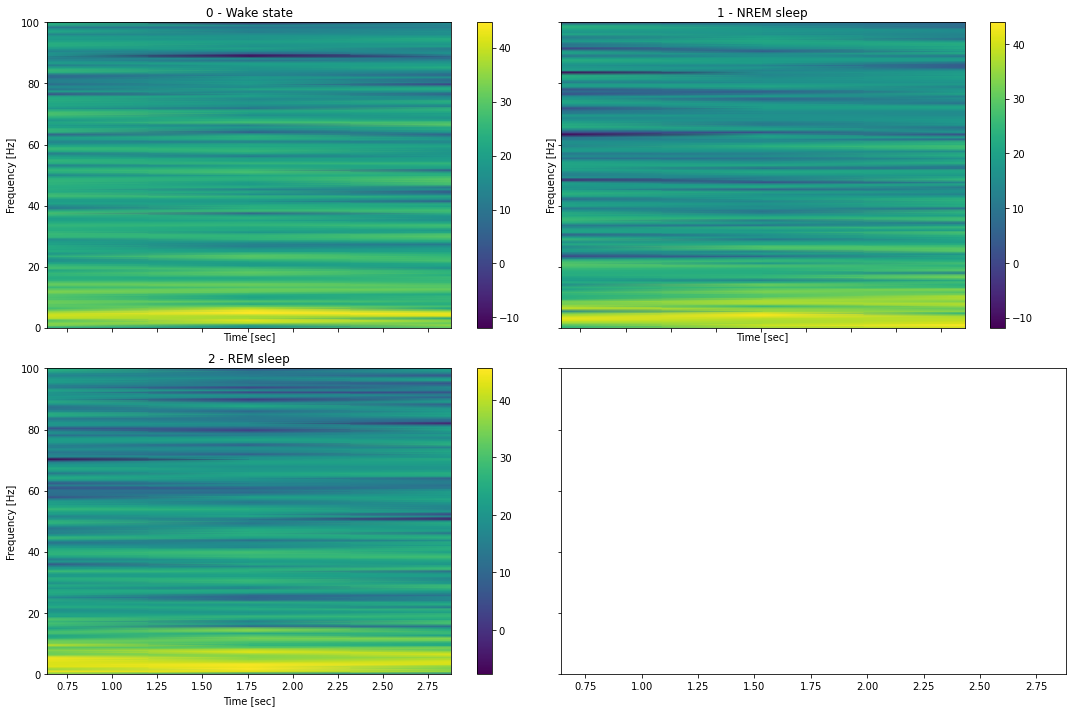

In [11]:
from scipy import signal
example_index = [4701, 4709, 0]

# Sampling rate is 200 Hz
Fs = 200   

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharex=True, sharey=True)

for i in range(3):
    ax = axs[i//2][i%2]
    f, t, Sxx = signal.spectrogram(features[example_index[i], :], 
                                   Fs, window=signal.get_window('hann',256))
    
    image = ax.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
    fig.colorbar(image, ax=ax)
    ax.set_title(label_names[i])
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

plt.tight_layout()
plt.show()

In [13]:
# Extract power spectrum from a nonstationary signal’s frequency content over 4-second EEG recordings as features 
f, t, sxx_features = signal.spectrogram(features, Fs, window=signal.get_window('hann',256))
new_sxx_features = sxx_features.reshape(len(labels), -1)

Use Principal Components Analysis (PCA) to get the most relevant information out of 387 components

In [14]:
# Choosing the number of components in PCA
from sklearn.decomposition import PCA

n_max = np.size(new_sxx_features,1) # Maximum amount of components
threshold = 0.999    # Threshold for selecting good number of components

pca = PCA(n_components=n_max).fit(new_sxx_features)
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)
min_components = np.amin(np.where(cum_var_ratio >= threshold)) + 1 

print(f"Number of components selected: {min_components}")
print(f"Proportion of variance explained: {cum_var_ratio[min_components-1]}")

Number of components selected: 127
Proportion of variance explained: 0.9990131498001008


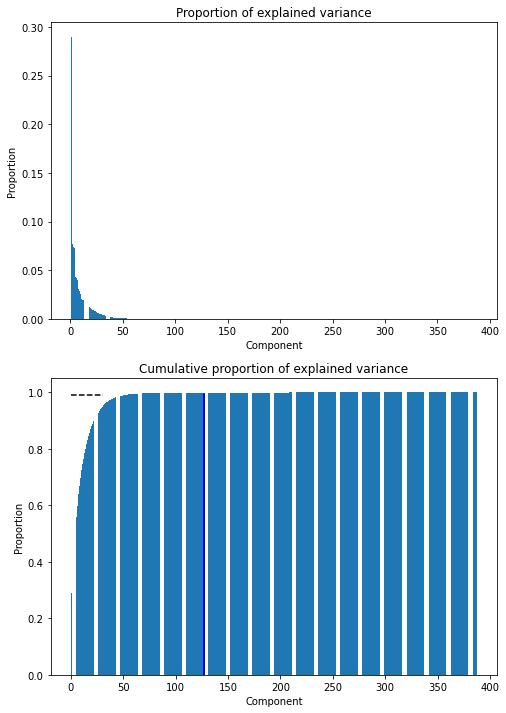

In [15]:
# Plot the number of PCs vs the reconstruction error
fig, ax = plt.subplots(2, 1, figsize=(8,12))
x_bar = range(1, n_max+1)
ax[0].bar(x_bar, var_ratio)
ax[0].set_title("Proportion of explained variance") 
ax[0].set_xlabel("Component")
ax[0].set_ylabel("Proportion")
barlist = ax[1].bar(x_bar, cum_var_ratio)
barlist[min_components-1].set_color('b')
ax[1].plot([0,31], [0.99, 0.99], '--', color='black')
ax[1].set_title("Cumulative proportion of explained variance")
ax[1].set_xlabel("Component")
ax[1].set_ylabel("Proportion")
plt.show() 

In [16]:
new_pca = PCA(n_components=min_components).fit(new_sxx_features)
X_transform = new_pca.transform(new_sxx_features)

### Data spliting into training and validation dataset using k-fold validation

In [17]:
from sklearn.model_selection import KFold

K = 5
kf = KFold(n_splits=K, shuffle=False)    # Create a KFold object with 'K' splits

### Data training

First, I create an additional function that runs the training model.

In [18]:
def testing_model(model, X, y, split_data_method=kf):
    """
    The function returns the accuracy result on training dataset  
    and validation dataset using training model as input parameter
    :pararm model: Model used for training
    :param X: features matrix
    :param y: labels vector
    :default param split_data_method: spliting data using K Fold cross validation 
    :return accu_train: training accuracy
    :return accu_val: validation accuracy
    """
    
    train_accu_per_cv_iteration = []
    val_accu_per_cv_iteration = []

    for train_indices, test_indices in kf.split(X):
        X_train = X[train_indices, :]  
        y_train = y[train_indices]
        training_model = model.fit(X_train, y_train)
        
        # Calculate training accuracy 
        train_pred = training_model.predict(X_train)
        train_score = metrics.accuracy_score(y_train, train_pred)
        train_accu_per_cv_iteration.append(train_score)

        # Calculate validation accuracy 
        X_val = X[test_indices, :]
        y_val = y[test_indices]

        val_pred = training_model.predict(X_val)
        val_score = metrics.accuracy_score(y_val, val_pred) 
        val_accu_per_cv_iteration.append(val_score)

    accu_train = np.mean(train_accu_per_cv_iteration, axis = 0) * 100
    accu_val = np.mean(val_accu_per_cv_iteration, axis = 0) * 100

    return accu_train, accu_val

### Logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [24]:
log_reg = LogisticRegression(random_state=1, multi_class="ovr", max_iter=1e5)
training_accuracy, validation_accuracy = testing_model(log_reg, X_transform, labels)
print(f'Avearge training accuracy is {training_accuracy}%')
print(f'Avearge validation accuracy is {validation_accuracy}%')

Avearge training accuracy is 80.17449635769115%
Avearge validation accuracy is 63.689728253901215%


#### Tuning parameters
I will try tune parameter C which is the inverse of regularization strength, the smaller this values, the stronger regularization will be. The default value of C is 1.

In [25]:
c_range = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

log_training = []
log_validation = []

for c in c_range:
    log_reg = LogisticRegression(random_state=1, multi_class="ovr", C=c, max_iter=1e5)
    training_accuracy, validation_accuracy = testing_model(log_reg, X_transform, labels)
    log_training.append(training_accuracy)
    log_validation.append(validation_accuracy)

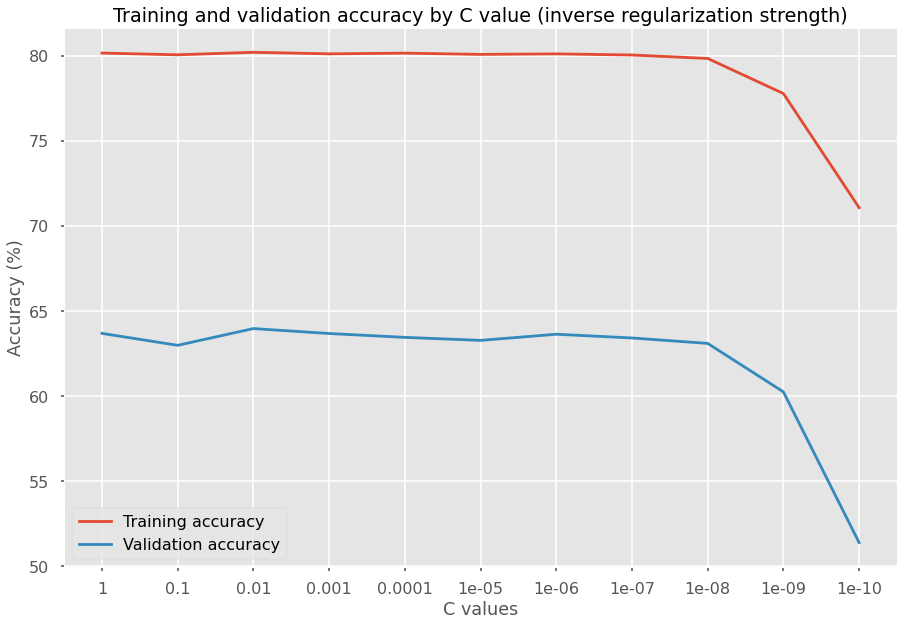

In [42]:
plt.style.use('seaborn-poster')  
plt.plot([str(c) for c in c_range], log_training, label='Training accuracy')
plt.plot([str(c) for c in c_range], log_validation, label='Validation accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('C values')
plt.ylabel('Accuracy (%)')
plt.title('Training and validation accuracy by C value (inverse regularization strength)')
plt.tight_layout()
plt.show()

I can see that the training error and validation error stays the same at around 80% and 64% respectively and then drastically decreases with the C values from 1e-07. Therefore, with Logistic Regression, I can just set C value as its default value.

### Decision tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
tree_model = DecisionTreeClassifier(random_state=1)
training_accuracy, validation_accuracy = testing_model(tree_model, X_transform, labels)
print(f'Avearge training accuracy is {training_accuracy}%')
print(f'Avearge validation accuracy is {validation_accuracy}%')

Avearge training accuracy is 100.0%
Avearge validation accuracy is 51.16717576635216%


This is a classic example of ovefitting where training accuracy is 100% and the validation accuracy is around 50%.

#### Tuning parameters

I am going to tune several parameters: min_sample_leaf, max_depth, max_features to try to avoid overfitting.

#### min_sample_leaf

In [29]:
tree_min_leaf_training = []
tree_min_leaf_validation = []

min_sample_list = range(1, min_components+1, 2)

for num in min_sample_list:
    tree_model = DecisionTreeClassifier(random_state=1, min_samples_leaf=num)
    training_accuracy, validation_accuracy = testing_model(tree_model, X_transform, labels)
    tree_min_leaf_training.append(training_accuracy)
    tree_min_leaf_validation.append(validation_accuracy)

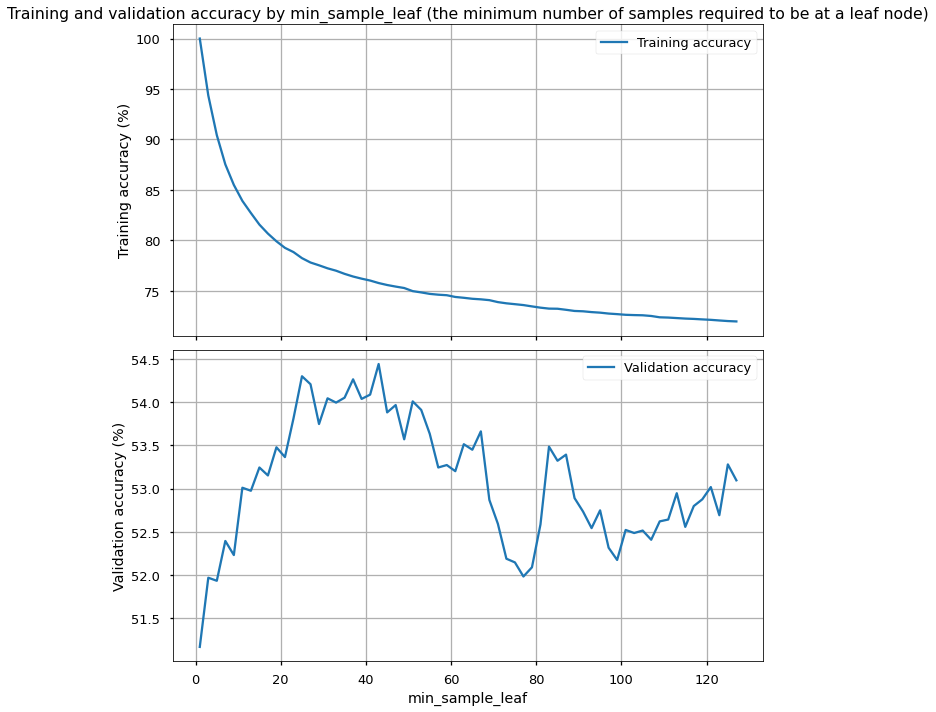

In [30]:
plt.style.use('seaborn-talk')  
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,10), sharex=True)
axs[0].set_title('Training and validation accuracy by min_sample_leaf (the minimum number of samples required to be at a leaf node)')

accuracy_dict = {'Training accuracy': tree_min_leaf_training, 'Validation accuracy': tree_min_leaf_validation}
for i, (label_name, accuracy) in enumerate(accuracy_dict.items()):
    axs[i].set_ylabel(f'{label_name} (%)')
    axs[i].plot(min_sample_list, accuracy, label=label_name)
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('min_sample_leaf')
plt.tight_layout()
plt.show()

In [55]:
best_num_index = np.argsort(np.array(tree_min_leaf_validation))
print('Best values of min_sample_leaf is', min_sample_list[best_num_index[-1]])

Best values of min_sample_leaf is 43


As shown from the graph above, the training accuracy decreases more quickly when min_sample_leaf is in the range 1 to 25 than the rest while validation error shows an opposite trend. However, the decrease in training accuracy is just a sign of reducing overfitting and the lowest training accuracy can get is around 73% which indicates that the model hasn't suffered from undertraining yet. On the other hand, the validation accuracy can only reach its peak at 54.5% with min_sample_leaf values at 43.

#### max_depth

Firstly, I need to know what is our range for tuning parameter max_depth. In order to know that, I can use our model using for tuning min_sample_leaf above to guide. 

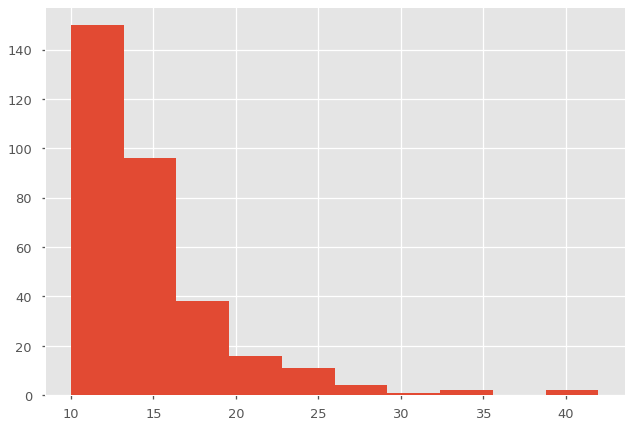

In [35]:
depth_list = []
for num in min_sample_list:
    for train_indices, test_indices in kf.split(X_transform):
        X_train = X_transform[train_indices, :]  
        y_train = labels[train_indices]
        
        tree_model = DecisionTreeClassifier(random_state=1, min_samples_leaf=num)
        tree_model = tree_model.fit(X_train, y_train)
        depth_list.append(tree_model.tree_.max_depth)
        
plt.style.use('ggplot')
plt.hist(depth_list)
plt.show()

For the histogram above, I can see that the depth of the tree is usualy from 10 to 25. Since the higher larger the depth, the easier the model get overfitted, we will use 25 as the upper limit. However, since I don't know whether if the model can get underfitted if using max_depth lower than 10 or not, I have to try and set the lower limit to 8.

In [36]:
depth_list = range(8, 26)

tree_depth_training = []
tree_depth_validation = []

for depth in depth_list:
    tree_model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    training_accuracy, validation_accuracy = testing_model(tree_model, X_transform, labels)
    tree_depth_training.append(training_accuracy)
    tree_depth_validation.append(validation_accuracy)

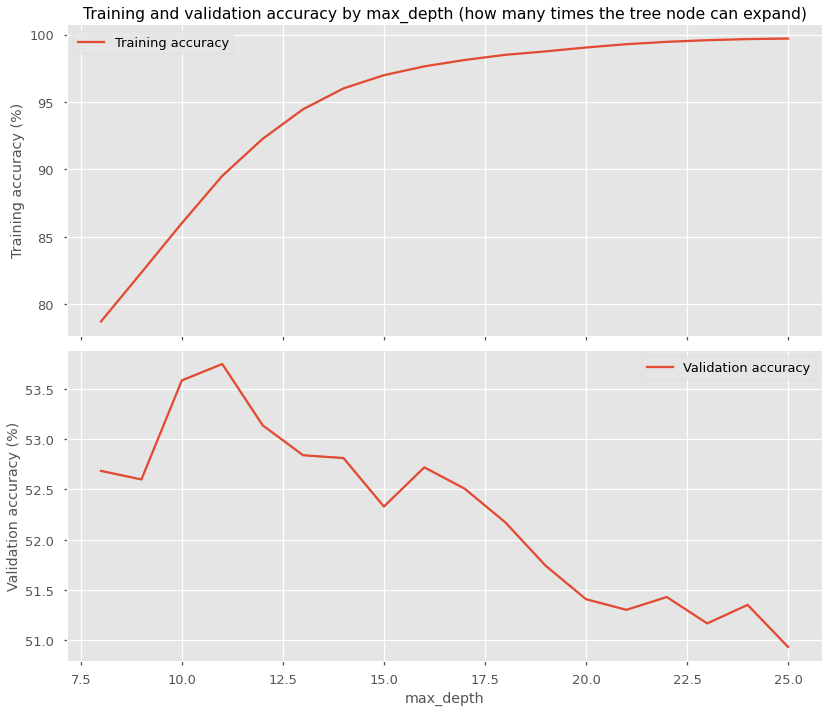

In [37]:
plt.style.use('seaborn-talk')  
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,10), sharex=True)
axs[0].set_title('Training and validation accuracy by max_depth (how many times the tree node can expand)')

accuracy_dict = {'Training accuracy': tree_depth_training, 'Validation accuracy': tree_depth_validation}
for i, (label_name, accuracy) in enumerate(accuracy_dict.items()):
    axs[i].set_ylabel(f'{label_name} (%)')
    axs[i].plot(depth_list, accuracy, label=label_name)
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('max_depth')
plt.tight_layout()
plt.show()

In [56]:
best_sample_index = np.argsort(np.array(tree_depth_validation))
print('Best values of min_sample_leaf is', depth_list[best_sample_index[-1]])

Best values of min_sample_leaf is 11


Since, again, the training accuracy is quite high (always larger than or equal to 85%), I don't have to worry about undertraining, but, still, our model can easily fall into overtraining. In this case, we just simply choose the max_depth value corresponding with the highest validation accuracy (around 53.7%) which is 11.

#### max_leaf_nodes

In [49]:
max_leaf_list = range(2,60,2)

tree_max_leaf_training = []
tree_max_leaf_validation = []

for leaf in max_leaf_list:
    tree_model = DecisionTreeClassifier(random_state=1, max_leaf_nodes=leaf)
    training_accuracy, validation_accuracy = testing_model(tree_model, X_transform, labels)
    tree_max_leaf_training.append(training_accuracy)
    tree_max_leaf_validation.append(validation_accuracy)

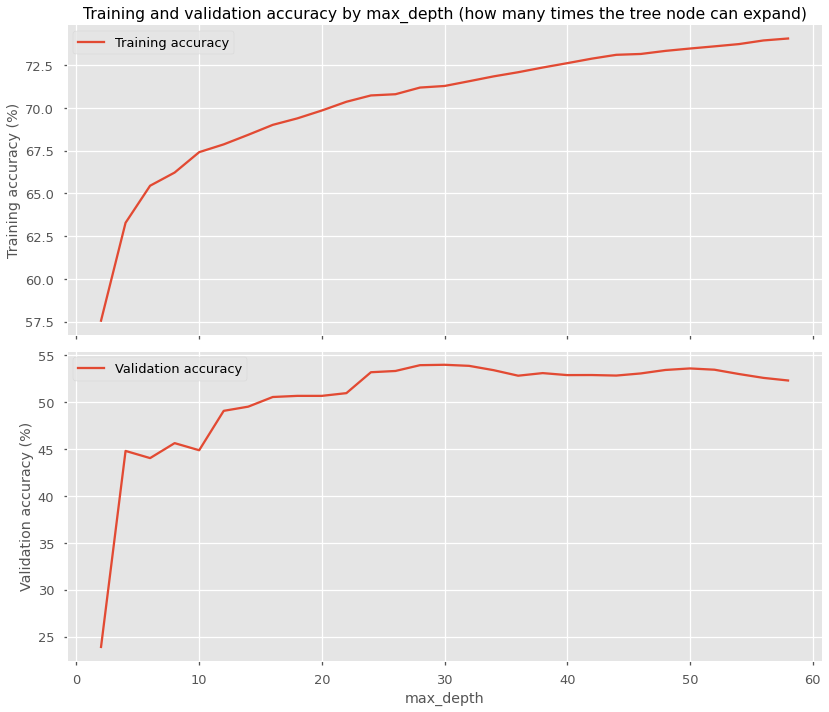

In [50]:
plt.style.use('seaborn-talk')  
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,10), sharex=True)
axs[0].set_title('Training and validation accuracy by max_depth (how many times the tree node can expand)')

accuracy_dict = {'Training accuracy': tree_max_leaf_training, 'Validation accuracy': tree_max_leaf_validation}
for i, (label_name, accuracy) in enumerate(accuracy_dict.items()):
    axs[i].set_ylabel(f'{label_name} (%)')
    axs[i].plot(max_leaf_list, accuracy, label=label_name)
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('max_depth')
plt.tight_layout()
plt.show()

Both training and validation accuracy increase according to max_depth but the validation accuracy reaches a plateau when max_depth starts reaching 25. Therefore, using value 25 seems to be a good idea as it could generalize the model enough while not let the model overfits. 

## Results
So far, I have just consider Logistic Regression and Decision Tree. As the results are shown above, Logistic Regression is still the best model with the training accuracy is 80.17% and the validation accuracy is 63.69%.

## Conclusion 

This project so far has just only concern with 2 models which are Logistic Regression and Decision Tree Classification. The training and validatoin accuracy on the best model, Logistic Regression, is fine, but not so good and I think there are still a lot of rooms for improvement. There are still many potential model like KNeighbor, SVM, or Neural Network. Moreover, in the cleaning data process, especially in dimensionality reduction process, LDA (Linear Discriminant Analysis) could be a good choice as it choose the dimension based on the difference on classes instead of variance in features. Furthermore, in this project, I have alreday removed artefact since I cannot find any feasiable to detect artefact.